## Dự án: Dự báo thời tiết Việt Nam bằng RNN & LSTM (Keras)

Mục tiêu:
- Xây dựng hệ thống dự báo chuỗi thời gian cho nhiều vùng tại Việt Nam (Bắc, Trung, Nam) và nhiều biến (Nhiệt độ, Độ ẩm, Lượng mưa, Tốc độ gió nếu có).
- Huấn luyện 2 mô hình sâu độc lập:
  - Deep RNN (SimpleRNN)
  - Deep LSTM
- Mỗi mô hình có tối thiểu 7 lớp (không tính Input), có Dropout và BatchNormalization.
- Sử dụng cửa sổ trượt (ví dụ 30 ngày quá khứ → dự báo 1 ngày tương lai).

Dữ liệu:
- File: `weather-vn.csv` trong thư mục hiện tại.

Kết quả:
- Pipeline tiền xử lý dữ liệu, tạo dữ liệu giám sát, huấn luyện, đánh giá (MAE/RMSE), vẽ đồ thị.
- Lưu mô hình và scaler để triển khai sau: thư mục `models/`.


In [ ]:
# Imports & environment setup
import os
import json
import math
import random
from datetime import datetime
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
DATA_PATH = os.path.join(os.path.dirname(__file__), 'weather-vn.csv') if '__file__' in globals() else 'weather-vn.csv'
ARTIFACT_DIR = 'models'
os.makedirs(ARTIFACT_DIR, exist_ok=True)
FIG_DIR = 'figs'
os.makedirs(FIG_DIR, exist_ok=True)

# Matplotlib style
plt.style.use('seaborn-v0_8')

print('TensorFlow:', tf.__version__)
print('Data path:', DATA_PATH)


TensorFlow: 2.20.0
Data path: weather-vn.csv


In [14]:
# Configuration & constants
LOOKBACK_DAYS = 30       # sliding window size
HORIZON_DAYS = 1         # predict next day
BATCH_SIZE = 256
EPOCHS = 50
VAL_SPLIT = 0.1
TEST_FRACTION = 0.15     # last 15% as test set (by time)
SCALER_TYPE = 'minmax'   # 'minmax' or 'standard'
USE_FRACTION = 1.0       # set < 1.0 to sample for quick tests

# Target variables (multi-output regression). We will detect which exist.
CANDIDATE_TARGETS = [
    'temperature', 'temp', 'tavg', 'tmean',
    'humidity', 'rh',
    'rainfall', 'precip', 'precipitation', 'rain',
    'wind_speed', 'wind', 'windspd'
]

# Column name candidates
DATE_COL_CANDIDATES = ['date', 'time', 'datetime', 'timestamp', 'day']
REGION_COL_CANDIDATES = ['region', 'vung', 'area', 'zone']
PROVINCE_COL_CANDIDATES = ['province', 'tinh', 'city', 'station', 'location', 'site']

# Province → 3-region mapping (North, Central, South). Can be extended.
PROVINCE_TO_REGION3 = {
    # North
    'ha noi': 'North', 'hai phong': 'North', 'quang ninh': 'North', 'hai duong': 'North',
    'bac ninh': 'North', 'bac giang': 'North', 'lang son': 'North', 'lao cai': 'North',
    'yen bai': 'North', 'son la': 'North', 'hoa binh': 'North', 'ha giang': 'North',
    'tuyen quang': 'North', 'phu tho': 'North', 'thai nguyen': 'North', 'nam dinh': 'North',
    'thai binh': 'North', 'ninh binh': 'North', 'bac kan': 'North', 'dien bien': 'North',
    'cao bang': 'North', 'lai chau': 'North', 'vinh phuc': 'North', 'quang ninh': 'North',

    # Central
    'thua thien hue': 'Central', 'da nang': 'Central', 'quang nam': 'Central', 'quang ngai': 'Central',
    'binh dinh': 'Central', 'phu yen': 'Central', 'khanh hoa': 'Central', 'ninh thuan': 'Central',
    'binh thuan': 'Central', 'quang tri': 'Central', 'quang binh': 'Central', 'ha tinh': 'Central',
    'nghe an': 'Central', 'thanh hoa': 'Central', 'dak lak': 'Central', 'dak nong': 'Central',
    'gia lai': 'Central', 'kon tum': 'Central', 'lam dong': 'Central'
,
    # South
    'ho chi minh': 'South', 'can tho': 'South', 'dong nai': 'South', 'ba ria-vung tau': 'South',
    'ba ria - vung tau': 'South', 'binh duong': 'South', 'binh phuoc': 'South', 'tay ninh': 'South',
    'long an': 'South', 'tien giang': 'South', 'ben tre': 'South', 'tra vinh': 'South',
    'vinh long': 'South', 'dong thap': 'South', 'an giang': 'South', 'kien giang': 'South',
    'hau giang': 'South', 'soc trang': 'South', 'bac lieu': 'South', 'ca mau': 'South'
}

# Utility helpers

def make_scaler(kind: str):
    if kind == 'minmax':
        return MinMaxScaler()
    if kind == 'standard':
        return StandardScaler()
    raise ValueError('Unknown scaler type')



In [15]:
# Load CSV and harmonize column names

def detect_first_existing(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name in cols:
            return cols[name]
    return None

# Read with dtype inference but force low_memory=False for safety
raw_df = pd.read_csv(DATA_PATH, low_memory=False)
print('Raw shape:', raw_df.shape)
print('Columns:', list(raw_df.columns)[:20])

# Lowercase simplified columns map for flexible access
lower_map = {c.lower(): c for c in raw_df.columns}

# Detect date/time column
date_col = detect_first_existing(raw_df, DATE_COL_CANDIDATES)
if date_col is None:
    raise ValueError('No date/time column found. Expected one of: ' + ', '.join(DATE_COL_CANDIDATES))

# Parse datetime and sort
raw_df[date_col] = pd.to_datetime(raw_df[date_col], errors='coerce')
raw_df = raw_df.dropna(subset=[date_col]).sort_values(by=[date_col])

# Detect region or province
region_col = detect_first_existing(raw_df, REGION_COL_CANDIDATES)
province_col = detect_first_existing(raw_df, PROVINCE_COL_CANDIDATES)

# Build `region3` column (North/Central/South)
if region_col is not None:
    region_series = raw_df[region_col].astype(str).str.strip()
else:
    region_series = pd.Series([None] * len(raw_df))

if province_col is not None:
    province_series = raw_df[province_col].astype(str).str.strip()
else:
    province_series = pd.Series([None] * len(raw_df))

# Prefer provided region if it looks like 3-region labels; otherwise map from province/city/station
region3 = []
for r, p in zip(region_series.fillna(''), province_series.fillna('')):
    r_l = str(r).lower()
    p_l = str(p).lower()
    val = None
    if r_l in {'north', 'bac', 'mien bac'}:
        val = 'North'
    elif r_l in {'central', 'trung', 'mien trung'}:
        val = 'Central'
    elif r_l in {'south', 'nam', 'mien nam'}:
        val = 'South'
    # try province mapping
    if val is None and p_l:
        val = PROVINCE_TO_REGION3.get(p_l)
    if val is None and r_l:
        val = PROVINCE_TO_REGION3.get(r_l)  # in case region col is a province name
    if val is None:
        val = 'Unknown'
    region3.append(val)

raw_df['region3'] = region3

# Keep only known regions for modeling; if Unknown exists, keep as separate category
print(raw_df[['region3']].value_counts().head())

# Normalize candidate target columns → standardized names
name_aliases = {
    'temperature': ['temperature', 'temp', 'tavg', 'tmean'],
    'humidity': ['humidity', 'rh'],
    'rainfall': ['rainfall', 'precip', 'precipitation', 'rain'],
    'wind_speed': ['wind_speed', 'wind', 'windspd']
}

standard_cols = {}
for std, aliases in name_aliases.items():
    for a in aliases:
        if a in lower_map:
            standard_cols[std] = lower_map[a]
            break

print('Detected variables:', standard_cols)
if not standard_cols:
    raise ValueError('No target variables detected. Ensure file has temperature/humidity/rainfall/wind columns.')

# Build a working DataFrame with standardized names
work_cols = {
    'date': date_col,
    'region3': 'region3',
}
work_cols.update(standard_cols)

df = raw_df[list(work_cols.values())].copy()
df.columns = list(work_cols.keys())

# Ensure numeric types
for c in ['temperature', 'humidity', 'rainfall', 'wind_speed']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print('Working shape:', df.shape)
df.head()

Raw shape: (925026, 20)
Columns: ['time', 'province', 'city', 'temperature', 'temp_min', 'temp_max', 'humidity', 'feels_like', 'visibility', 'precipitation', 'cloudcover', 'wind_speed', 'wind_gust', 'wind_direction', 'pressure', 'is_day', 'weather_code', 'weather_main', 'weather_description', 'weather_icon']
region3
Unknown    444634
North      211045
Central    140578
South      128769
Name: count, dtype: int64
Detected variables: {'temperature': 'temperature', 'humidity': 'humidity', 'rainfall': 'precipitation', 'wind_speed': 'wind_speed'}
Working shape: (925026, 6)


,date,region3,temperature,humidity,rainfall,wind_speed
0,2025-06-29 23:29:00,Unknown,25.63,79,0.00,2.36
632354,2025-06-29 23:29:00,Central,26.99,74,0.00,5.08
480069,2025-06-29 23:29:00,Central,21.51,98,0.00,0.45
784548,2025-06-29 23:29:00,Unknown,26.63,93,9.99,2.12
140397,2025-06-29 23:29:00,Unknown,25.88,89,0.00,2.57


In [ ]:
# Preprocess: daily aggregation, missing-value handling

# Keep only columns present
target_cols = [c for c in ['temperature','humidity','rainfall','wind_speed'] if c in df.columns]
assert len(target_cols) > 0, 'No target columns detected after normalization.'

# Aggregate to daily by region (mean for continuous, sum for rainfall often makes sense – but we keep mean for simplicity).
# If rainfall represents daily total already, averaging per day across stations in a region is acceptable.

agg_map = {c: 'mean' for c in target_cols}

# Create complete daily index per region
all_regions = df['region3'].unique().tolist()

processed = []
for region in all_regions:
    dfr = df[df['region3'] == region].copy()
    dfr = dfr.set_index('date').sort_index()
    # Aggregate to daily using resample to avoid duplicate-label issues
    dfr_daily = dfr.resample('D').mean(numeric_only=True)
    # Add back region label after resample
    dfr_daily['region3'] = region
    
    # Missing handling: interpolate time-wise then fill remaining with median
    for c in target_cols:
        if c in dfr_daily.columns:
            dfr_daily[c] = dfr_daily[c].interpolate(method='time', limit_direction='both')
    for c in target_cols:
        if c in dfr_daily.columns:
            med = dfr_daily[c].median()
            dfr_daily[c] = dfr_daily[c].fillna(med)
    processed.append(dfr_daily.reset_index())

proc_df = pd.concat(processed, axis=0, ignore_index=True)
proc_df = proc_df.sort_values(['region3', 'date']).reset_index(drop=True)

print('Processed shape:', proc_df.shape)
proc_df.head()

Processed shape: (76, 6)


,date,temperature,humidity,rainfall,wind_speed,region3
0,2025-06-29,24.355208,86.572917,0.000000,2.344948,Central
1,2025-06-30,26.885898,77.974538,0.091810,2.786577,Central
2,2025-07-01,26.730494,82.148083,0.268468,2.195280,Central
3,2025-07-02,26.816229,80.929822,0.408953,1.996292,Central
4,2025-07-03,24.333025,87.308471,0.046469,1.875483,Central


In [ ]:
# Sliding window dataset creation (per region), scaling, and splits

from itertools import chain

# One-hot encode region3
region_dummies = pd.get_dummies(proc_df['region3'], prefix='region')
proc_df_ohe = pd.concat([proc_df[['date']], region_dummies, proc_df[target_cols]], axis=1)

# Build feature and target column lists
region_feature_cols = list(region_dummies.columns)
feature_cols = region_feature_cols + target_cols  # using past values of targets as features

# Optionally downsample for faster prototyping
if 0 < USE_FRACTION < 1.0:
    # sample by time uniformly per region to keep temporal structure roughly intact
    sampled = []
    for rcol in region_dummies.columns:
        # find region name from dummy column (region_<name>)
        region_name = rcol.split('region_')[-1]
        # mask rows for this region
        mask = region_dummies[rcol] == 1
        dfr = proc_df_ohe[mask].copy()
        n = int(len(dfr) * USE_FRACTION)
        sampled.append(dfr.iloc[::max(1, len(dfr)//max(1,n))])
    proc_df_ohe = pd.concat(sampled, axis=0).sort_values('date')

# Train/val/test split by time (global time) – ensure no leakage
proc_df_ohe = proc_df_ohe.sort_values('date').reset_index(drop=True)
N = len(proc_df_ohe)

# Compute indices
test_size = int(N * TEST_FRACTION)
trainval_end = N - test_size

train_end = int(trainval_end * (1 - VAL_SPLIT))

train_df = proc_df_ohe.iloc[:train_end].reset_index(drop=True)
val_df   = proc_df_ohe.iloc[train_end:trainval_end].reset_index(drop=True)
test_df  = proc_df_ohe.iloc[trainval_end:].reset_index(drop=True)

print('Split sizes:', len(train_df), len(val_df), len(test_df))

# Fit scalers on training only
feature_scaler = make_scaler(SCALER_TYPE)
target_scaler = make_scaler(SCALER_TYPE)

# Important: do not scale one-hot columns
def split_features(df_):
    X_num = df_[target_cols].values.astype('float32')
    X_region = df_[region_feature_cols].values.astype('float32')
    return X_num, X_region

Xnum_train, Xreg_train = split_features(train_df)
Xnum_val, Xreg_val = split_features(val_df)
Xnum_test, Xreg_test = split_features(test_df)

# Fit numeric scaler on past targets only (features); target scaler on targets
feature_scaler.fit(Xnum_train)

# For target scaler, fit on the SAME numeric data distribution as the targets (use train targets)
# Here targets are the same columns as past targets
target_scaler.fit(train_df[target_cols].values.astype('float32'))

# Apply scaling to numeric part
Xnum_train_s = feature_scaler.transform(Xnum_train)
Xnum_val_s   = feature_scaler.transform(Xnum_val)
Xnum_test_s  = feature_scaler.transform(Xnum_test)

# Concatenate back with region one-hots for features
train_features_scaled = np.hstack([Xreg_train, Xnum_train_s]).astype('float32')
val_features_scaled   = np.hstack([Xreg_val, Xnum_val_s]).astype('float32')
test_features_scaled  = np.hstack([Xreg_test, Xnum_test_s]).astype('float32')

# Targets (unshifted here; will be built via sliding windows)
train_targets_raw = train_df[target_cols].values.astype('float32')
val_targets_raw   = val_df[target_cols].values.astype('float32')
test_targets_raw  = test_df[target_cols].values.astype('float32')

train_targets_scaled = target_scaler.transform(train_targets_raw)
val_targets_scaled   = target_scaler.transform(val_targets_raw)
test_targets_scaled  = target_scaler.transform(test_targets_raw)

# Helper: build sequences with lookback and horizon on aligned arrays

def build_sequences(features_2d: np.ndarray,
                    targets_2d: np.ndarray,
                    lookback: int,
                    horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    X_list, y_list = [], []
    # We assume features_2d and targets_2d are time-ordered rows
    for i in range(lookback, len(features_2d) - horizon + 1):
        X_win = features_2d[i - lookback:i]
        y_tgt = targets_2d[i + horizon - 1]  # next day
        X_list.append(X_win)
        y_list.append(y_tgt)
    if not X_list:
        return np.empty((0, lookback, features_2d.shape[1]), dtype='float32'), np.empty((0, targets_2d.shape[1]), dtype='float32')
    return np.stack(X_list).astype('float32'), np.stack(y_list).astype('float32')

# Build sequences per split
X_train, y_train = build_sequences(train_features_scaled, train_targets_scaled, LOOKBACK_DAYS, HORIZON_DAYS)
X_val,   y_val   = build_sequences(val_features_scaled,   val_targets_scaled,   LOOKBACK_DAYS, HORIZON_DAYS)
X_test,  y_test  = build_sequences(test_features_scaled,  test_targets_scaled,  LOOKBACK_DAYS, HORIZON_DAYS)

print('Sequence shapes:')
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val  :', X_val.shape,   'y_val  :', y_val.shape)
print('X_test :', X_test.shape,  'y_test :', y_test.shape)

# TF datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(8192, seed=SEED, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Split sizes: 58 7 11
Sequence shapes:
X_train: (28, 30, 8) y_train: (28, 4)
X_val  : (0, 30, 8) y_val  : (0, 4)
X_test : (0, 30, 8) y_test : (0, 4)


### Kiến trúc mô hình (7+ lớp, không tính Input)

- Deep RNN (SimpleRNN):
  1. SimpleRNN(128, return_sequences=True)
  2. BatchNormalization
  3. Dropout(0.2)
  4. SimpleRNN(128, return_sequences=True)
  5. BatchNormalization
  6. Dropout(0.2)
  7. SimpleRNN(64)
  8. BatchNormalization
  9. Dropout(0.2)
  10. Dense(128, relu)
  11. BatchNormalization
  12. Dropout(0.2)
  13. Dense(output_dim)

- Deep LSTM:
  1. LSTM(128, return_sequences=True)
  2. BatchNormalization
  3. Dropout(0.2)
  4. LSTM(128, return_sequences=True)
  5. BatchNormalization
  6. Dropout(0.2)
  7. LSTM(64)
  8. BatchNormalization
  9. Dropout(0.2)
  10. Dense(128, relu)
  11. BatchNormalization
  12. Dropout(0.2)
  13. Dense(output_dim)

Cả hai mô hình dùng Adam, loss MSE, metric MAE. Sử dụng EarlyStopping và ModelCheckpoint lưu mô hình tốt nhất.

In [ ]:
# Build models

input_shape = (LOOKBACK_DAYS, train_features_scaled.shape[1])
output_dim = len(target_cols)


def build_deep_rnn(input_shape, output_dim):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.SimpleRNN(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.SimpleRNN(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.SimpleRNN(64, return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])
    return model


def build_deep_lstm(input_shape, output_dim):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])
    return model

rnn_model = build_deep_rnn(input_shape, output_dim)
lstm_model = build_deep_lstm(input_shape, output_dim)

rnn_model.summary()
lstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 30, 128)        │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,412 (286.77 KB)

 Trainable params: 72,516 (283.27 KB)

 Non-trainable params: 896 (3.50 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,764 (1022.52 KB)

 Trainable params: 260,868 (1019.02 KB)

 Non-trainable params: 896 (3.50 KB)

Training Deep RNN...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 3.0931 - mae: 1.3893
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 3.0353 - mae: 1.3339
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.3770 - mae: 1.2442
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.2761 - mae: 1.1945
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.6363 - mae: 1.0240
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2319 - mae: 1.2221
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.0689 - mae: 1.1521
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.1984 - mae: 1.2013
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9614 - mae: 1.0832
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.8459 - mae: 1.0747
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.8138 - mae: 1.0329
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.8456 - mae: 1.1134
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

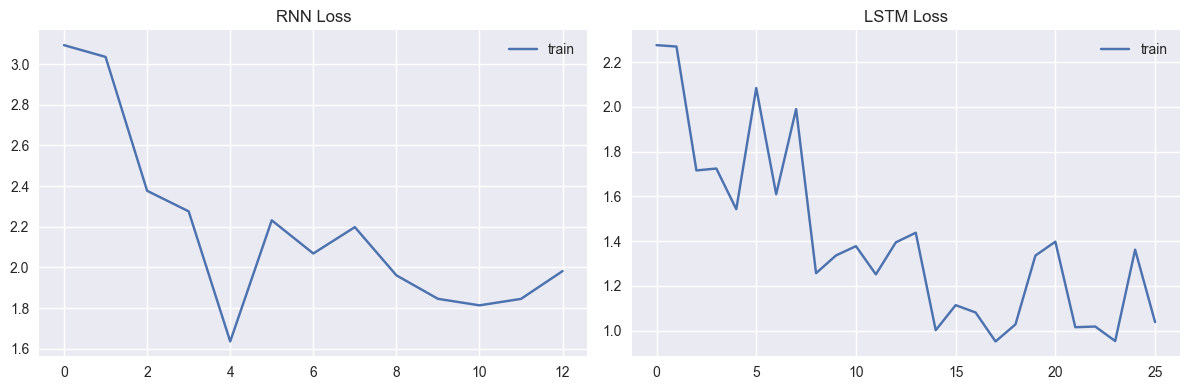

Saved training loss figure to: figs\training_loss.png


In [ ]:
# Train models with callbacks (robust to empty validation set)

has_val = X_val.shape[0] > 0
monitor_metric = 'val_loss' if has_val else 'loss'

common_callbacks = [
    callbacks.EarlyStopping(monitor=monitor_metric, patience=8, restore_best_weights=True),
]

rnn_ckpt_path = os.path.join(ARTIFACT_DIR, 'rnn_vn_weather.keras')
lstm_ckpt_path = os.path.join(ARTIFACT_DIR, 'lstm_vn_weather.keras')

rnn_ckpt = callbacks.ModelCheckpoint(rnn_ckpt_path, monitor=monitor_metric, save_best_only=True)
lstm_ckpt = callbacks.ModelCheckpoint(lstm_ckpt_path, monitor=monitor_metric, save_best_only=True)

print('Training Deep RNN...')
if has_val:
    hist_rnn = rnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=common_callbacks + [rnn_ckpt],
        verbose=1
    )
else:
    hist_rnn = rnn_model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=common_callbacks + [rnn_ckpt],
        verbose=1
    )

print('Training Deep LSTM...')
if has_val:
    hist_lstm = lstm_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=common_callbacks + [lstm_ckpt],
        verbose=1
    )
else:
    hist_lstm = lstm_model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=common_callbacks + [lstm_ckpt],
        verbose=1
    )

# Plot training vs validation loss (skip val if not available)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(hist_rnn.history['loss'], label='train')
if 'val_loss' in hist_rnn.history:
    axes[0].plot(hist_rnn.history['val_loss'], label='val')
axes[0].set_title('RNN Loss')
axes[0].legend()

axes[1].plot(hist_lstm.history['loss'], label='train')
if 'val_loss' in hist_lstm.history:
    axes[1].plot(hist_lstm.history['val_loss'], label='val')
axes[1].set_title('LSTM Loss')
axes[1].legend()

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, 'training_loss.png')
plt.savefig(fig_path, dpi=150)
plt.show()

print('Saved training loss figure to:', fig_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
RNN metrics (train):
overall {'MAE': 3.8280608654022217, 'RMSE': 6.003207938610758}
temperature {'MAE': 3.7173478603363037, 'RMSE': 4.0252074857508555}
humidity {'MAE': 8.898848533630371, 'RMSE': 11.016231352438512}
rainfall {'MAE': 0.39470797777175903, 'RMSE': 0.4985952014238492}
wind_speed {'MAE': 2.3013389110565186, 'RMSE': 2.5190807797396086}

LSTM metrics (train):
overall {'MAE': 2.1632134914398193, 'RMSE': 3.1865922719925064}
temperature {'MAE': 3.2512800693511963, 'RMSE': 3.3662360101601063}
humidity {'MAE': 3.794806957244873, 'RMSE': 5.149329517754897}
rainfall {'MAE': 0.19927427172660828, 'RMSE': 0.33964100632701194}
wind_speed {'MAE': 1.4074928760528564, 'RMSE': 1.6294129678965186}


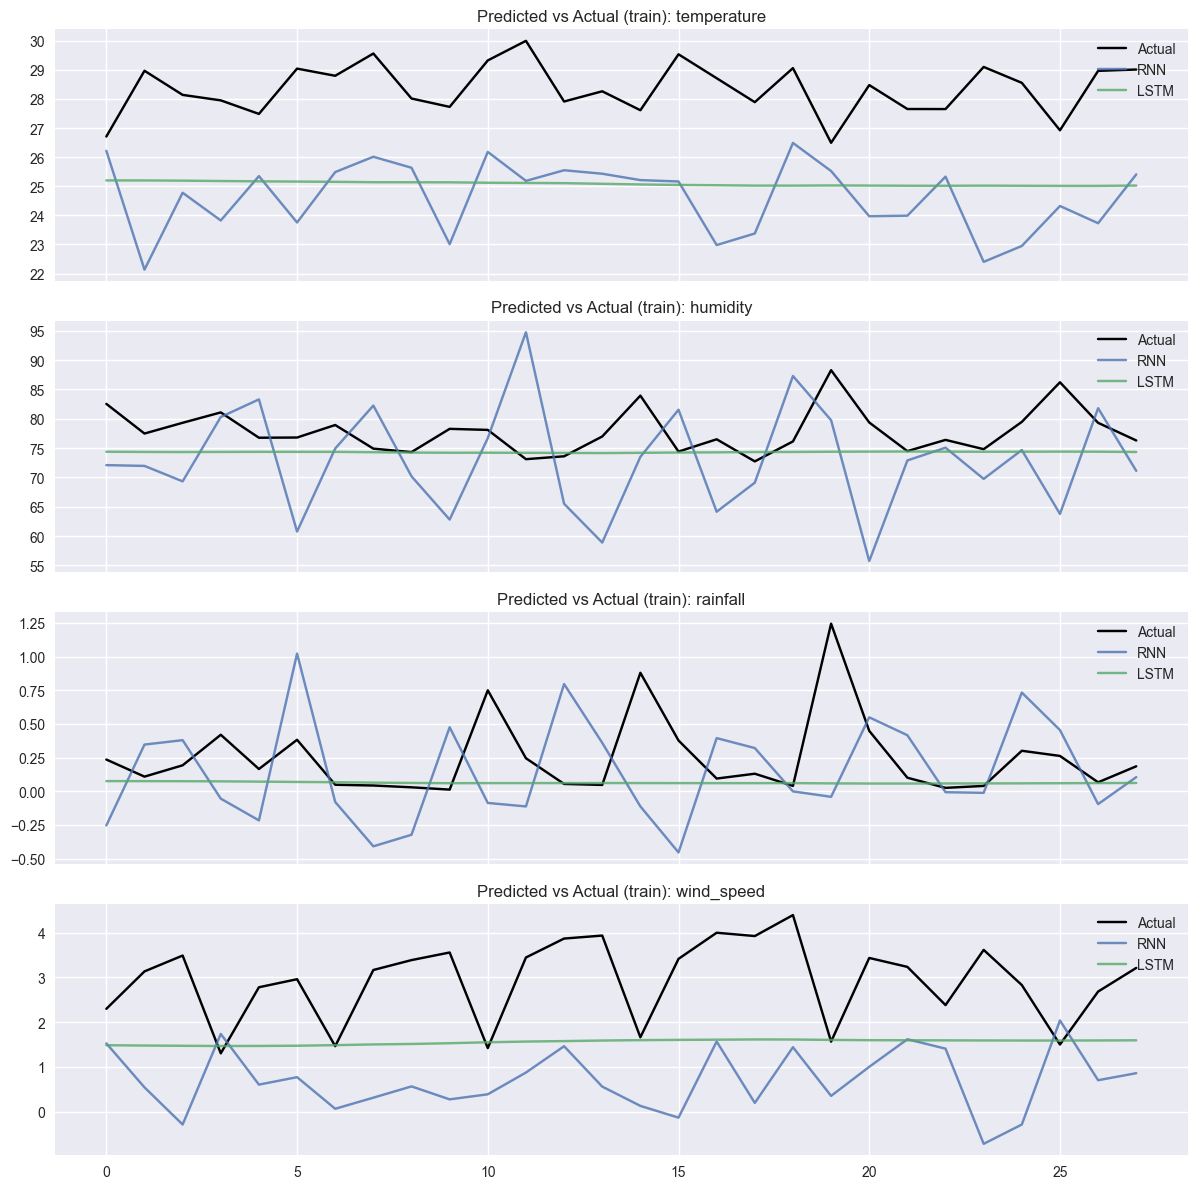

Saved prediction plot to: figs\pred_vs_actual_train.png


In [ ]:
# Evaluation: MAE and RMSE; Predicted vs Actual plots (robust to missing variables)

# Choose evaluation split safely
_eval = None
if 'X_test' in globals() and isinstance(X_test, np.ndarray) and X_test.shape[0] > 0:
    _eval = (X_test, y_test, 'test')
elif 'X_val' in globals() and isinstance(X_val, np.ndarray) and X_val.shape[0] > 0:
    _eval = (X_val, y_val, 'val')
elif 'X_train' in globals() and isinstance(X_train, np.ndarray) and X_train.shape[0] > 0:
    _eval = (X_train, y_train, 'train')

if _eval is None:
    print('No sequences available in test/val/train. Run preprocessing and training cells first.')
    raise SystemExit

eval_X, eval_y, split_name = _eval

# Load checkpoints if present; otherwise use in-memory models
rnn_ckpt = os.path.join(ARTIFACT_DIR, 'rnn_vn_weather.keras')
lstm_ckpt = os.path.join(ARTIFACT_DIR, 'lstm_vn_weather.keras')

if os.path.exists(rnn_ckpt):
    rnn_model = tf.keras.models.load_model(rnn_ckpt)
if os.path.exists(lstm_ckpt):
    lstm_model = tf.keras.models.load_model(lstm_ckpt)

# Ensure models exist
if 'rnn_model' not in globals() or 'lstm_model' not in globals():
    raise RuntimeError('Models not available. Train models first or ensure checkpoints exist.')

# Predict directly on arrays
y_pred_rnn_s = rnn_model.predict(eval_X, batch_size=BATCH_SIZE, verbose=1)
y_pred_lstm_s = lstm_model.predict(eval_X, batch_size=BATCH_SIZE, verbose=1)

# Inverse scale if scaler exists and shapes match
if 'target_scaler' in globals():
    try:
        y_true = target_scaler.inverse_transform(eval_y)
        y_pred_rnn = target_scaler.inverse_transform(y_pred_rnn_s)
        y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_s)
    except Exception:
        y_true = eval_y
        y_pred_rnn = y_pred_rnn_s
        y_pred_lstm = y_pred_lstm_s
else:
    y_true = eval_y
    y_pred_rnn = y_pred_rnn_s
    y_pred_lstm = y_pred_lstm_s

# Metrics per variable and overall

def compute_metrics(y_true, y_pred, names):
    results = {}
    mae_all = mean_absolute_error(y_true, y_pred)
    rmse_all = math.sqrt(mean_squared_error(y_true, y_pred))
    results['overall'] = {'MAE': mae_all, 'RMSE': rmse_all}
    for i, n in enumerate(names):
        mae_i = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse_i = math.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        results[n] = {'MAE': mae_i, 'RMSE': rmse_i}
    return results

metrics_rnn = compute_metrics(y_true, y_pred_rnn, target_cols)
metrics_lstm = compute_metrics(y_true, y_pred_lstm, target_cols)

print(f'RNN metrics ({split_name}):')
for k, v in metrics_rnn.items():
    print(k, v)
print(f'\nLSTM metrics ({split_name}):')
for k, v in metrics_lstm.items():
    print(k, v)

# Plot predicted vs actual for each target (last 200 points)
PLOT_N = min(200, len(y_true))
idx0 = max(0, len(y_true) - PLOT_N)

fig, axes = plt.subplots(len(target_cols), 1, figsize=(12, 3*len(target_cols)), sharex=True)
if len(target_cols) == 1:
    axes = [axes]

for i, col in enumerate(target_cols):
    axes[i].plot(y_true[idx0:, i], label='Actual', color='black')
    axes[i].plot(y_pred_rnn[idx0:, i], label='RNN', alpha=0.8)
    axes[i].plot(y_pred_lstm[idx0:, i], label='LSTM', alpha=0.8)
    axes[i].set_title(f'Predicted vs Actual ({split_name}): {col}')
    axes[i].legend(loc='upper right')

plt.tight_layout()
fig_path2 = os.path.join(FIG_DIR, f'pred_vs_actual_{split_name}.png')
plt.savefig(fig_path2, dpi=150)
plt.show()

print('Saved prediction plot to:', fig_path2)


In [21]:
# Save scalers and configuration for deployment
import joblib

scalers_path = os.path.join(ARTIFACT_DIR, 'scalers.joblib')
config_path = os.path.join(ARTIFACT_DIR, 'config.json')

joblib.dump({
    'feature_scaler': feature_scaler,
    'target_scaler': target_scaler
}, scalers_path)

config = {
    'lookback_days': LOOKBACK_DAYS,
    'horizon_days': HORIZON_DAYS,
    'feature_dim': int(train_features_scaled.shape[1]),
    'target_cols': target_cols,
    'region_feature_cols': region_feature_cols,
    'scaler_type': SCALER_TYPE,
}
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

print('Saved scalers to:', scalers_path)
print('Saved config to:', config_path)


Saved scalers to: models\scalers.joblib
Saved config to: models\config.json


### Ví dụ suy luận (inference)

Hàm tiện ích để nạp mô hình và dự báo 1 ngày tiếp theo cho một vùng (North/Central/South) dựa trên 30 ngày gần nhất từ `proc_df`.

In [22]:
# Simple inference utility

def build_latest_window_for_region(region_name: str) -> Optional[np.ndarray]:
    # get last LOOKBACK_DAYS rows for region
    mask = proc_df['region3'] == region_name
    dfr = proc_df[mask].sort_values('date').tail(LOOKBACK_DAYS)
    if len(dfr) < LOOKBACK_DAYS:
        print('Not enough data for region', region_name)
        return None
    # one-hot
    ohe = pd.get_dummies(dfr['region3'], prefix='region')
    # align columns to training
    for c in region_feature_cols:
        if c not in ohe.columns:
            ohe[c] = 0
    ohe = ohe[region_feature_cols]
    # numeric features
    xnum = dfr[target_cols].astype('float32').values
    xnum_s = feature_scaler.transform(xnum)
    feats = np.hstack([ohe.values.astype('float32'), xnum_s]).astype('float32')
    return feats[np.newaxis, ...]  # (1, lookback, feature_dim)

# Example usage (uncomment to run after training)
# region_example = 'North'
# X_latest = build_latest_window_for_region(region_example)
# if X_latest is not None:
#     pred_rnn_s = rnn_model.predict(X_latest)
#     pred_lstm_s = lstm_model.predict(X_latest)
#     pred_rnn = target_scaler.inverse_transform(pred_rnn_s)
#     pred_lstm = target_scaler.inverse_transform(pred_lstm_s)
#     print('Next-day prediction (RNN):', dict(zip(target_cols, pred_rnn.ravel())))
#     print('Next-day prediction (LSTM):', dict(zip(target_cols, pred_lstm.ravel())))


In [ ]:
# Vẽ bản đồ Việt Nam với 5 tỉnh và giá trị dự báo từ mô hình (độc lập, tự chuẩn bị dữ liệu từ file raw)
import os
import json
import folium
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# ---------- Cấu hình đường dẫn & model ----------
DATA_PATH = "weather-vn.csv"
config_path = os.path.join("models", "config.json")
scalers_path = os.path.join("models", "scalers.joblib")
lstm_path = os.path.join("models", "lstm_vn_weather.keras")

with open(config_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)
scalers = joblib.load(scalers_path)
feature_scaler = scalers["feature_scaler"]
target_scaler = scalers["target_scaler"]
target_cols = cfg["target_cols"]
region_feature_cols = cfg["region_feature_cols"]
LOOKBACK_DAYS = cfg["lookback_days"]

lstm_model = load_model(lstm_path)

# ---------- Map tỉnh → vùng (tối thiểu cho 5 tỉnh) ----------
PROVINCE_TO_REGION3 = {
    "ha noi": "North",
    "lang son": "North",
    "da nang": "Central",
    "ho chi minh": "South",
    "can tho": "South",
}

# ---------- Đọc biên giới Việt Nam từ GeoJSON ----------
with open("vn.json", encoding="utf-8") as f:
    vn_geo = json.load(f)

# ---------- Nạp dữ liệu thô và chuẩn hóa cột tối giản ----------
raw = pd.read_csv(DATA_PATH)

# Normalize column names: lowercase + strip spaces + remove BOM (tránh lỗi "thiếu cột" do header bị lệch)
raw.columns = (
    pd.Index(raw.columns)
    .astype(str)
    .str.replace("\ufeff", "", regex=False)
    .str.strip()
    .str.lower()
)

# Chọn cột thời gian (theo header thực tế: time)
if "time" in raw.columns:
    raw["date"] = pd.to_datetime(raw["time"], errors="coerce")
elif "date" in raw.columns:
    raw["date"] = pd.to_datetime(raw["date"], errors="coerce")
else:
    raise ValueError(
        "Không tìm thấy cột thời gian (time/date). "
        f"File đang đọc: {os.path.abspath(DATA_PATH)} | Columns: {list(raw.columns)[:50]}"
    )

# Map province -> region3
if "province" not in raw.columns:
    raise ValueError(
        "Không tìm thấy cột province trong dữ liệu. "
        f"File đang đọc: {os.path.abspath(DATA_PATH)} | Columns: {list(raw.columns)[:50]}"
    )
raw["province_key"] = raw["province"].astype(str).str.split("-").str[0].str.lower().str.strip()
raw["region3"] = raw["province_key"].map(PROVINCE_TO_REGION3).fillna("Unknown")

# Header thực tế có thể khác nhau giữa các file CSV.
# Ta cố gắng chuẩn hoá về đúng 4 cột mà model đã train: temperature, humidity, rainfall, wind_speed.

def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

# --- temperature ---
if "temperature" not in raw.columns:
    if "temp" in raw.columns:
        raw["temperature"] = _to_num(raw["temp"])
    elif "tavg" in raw.columns:
        raw["temperature"] = _to_num(raw["tavg"])
    elif "tmean" in raw.columns:
        raw["temperature"] = _to_num(raw["tmean"])
    # dataset khác của bạn đang có max/min
    elif "max" in raw.columns and "min" in raw.columns:
        raw["temperature"] = (_to_num(raw["max"]) + _to_num(raw["min"])) / 2

# --- humidity ---
if "humidity" not in raw.columns:
    if "rh" in raw.columns:
        raw["humidity"] = _to_num(raw["rh"])
    # dataset khác của bạn đang có humidi (bị cắt chữ)
    elif "humidi" in raw.columns:
        raw["humidity"] = _to_num(raw["humidi"])

# --- rainfall ---
if "rainfall" not in raw.columns:
    if "precipitation" in raw.columns:
        raw["rainfall"] = _to_num(raw["precipitation"])
    elif "precip" in raw.columns:
        raw["rainfall"] = _to_num(raw["precip"])
    # dataset khác của bạn đang có rain
    elif "rain" in raw.columns:
        raw["rainfall"] = _to_num(raw["rain"])

# --- wind_speed ---
if "wind_speed" not in raw.columns:
    if "windspd" in raw.columns:
        raw["wind_speed"] = _to_num(raw["windspd"])
    # dataset khác của bạn đang có wind
    elif "wind" in raw.columns:
        raw["wind_speed"] = _to_num(raw["wind"])

missing = [c for c in ["temperature", "humidity", "rainfall", "wind_speed"] if c not in raw.columns]
if missing:
    raise ValueError(
        "Thiếu cột cần thiết: " + ", ".join(missing) + ". "
        f"File đang đọc: {os.path.abspath(DATA_PATH)} | Columns: {list(raw.columns)[:50]}"
    )

proc_df = raw[["date", "region3", "temperature", "humidity", "rainfall", "wind_speed"]].copy()
proc_df = proc_df.dropna().sort_values("date")

# ---------- Helper: xây dựng window cuối cùng cho 1 vùng ----------
def build_latest_window_for_region(region_name: str):
    mask = proc_df["region3"] == region_name
    dfr = proc_df[mask].sort_values("date").tail(LOOKBACK_DAYS)
    if len(dfr) < LOOKBACK_DAYS:
        return None
    ohe = pd.get_dummies(dfr["region3"], prefix="region")
    for c in region_feature_cols:
        if c not in ohe.columns:
            ohe[c] = 0
    ohe = ohe[region_feature_cols]
    xnum = dfr[target_cols].astype("float32").values
    xnum_s = feature_scaler.transform(xnum)
    feats = np.hstack([ohe.values.astype("float32"), xnum_s]).astype("float32")
    return feats[np.newaxis, ...]

# ---------- Hàm dự báo cho 1 vùng ----------
def predict_region(region_name: str):
    X = build_latest_window_for_region(region_name)
    if X is None:
        return None
    pred_scaled = lstm_model.predict(X, verbose=0)
    pred = target_scaler.inverse_transform(pred_scaled)[0]
    return dict(zip(target_cols, pred))

# ---------- Dự báo cho ngày bạn chọn + hiển thị 63 tỉnh/thành từ vn.json ----------
# Lưu ý: model của bạn đang dự báo theo 3 vùng (North/Central/South), nên mỗi tỉnh trong cùng vùng sẽ nhận cùng giá trị dự báo.

import unicodedata
from datetime import date

import branca.colormap as cm
import ipywidgets as widgets
from IPython.display import display, clear_output

# Mở rộng map tỉnh → vùng (dùng danh sách đầy đủ hơn; thêm vài alias để khớp vn.json)
PROVINCE_TO_REGION3.update({
    # bổ sung còn thiếu / alias
    "ha nam": "North",
    "hung yen": "North",
    "bac kan": "North",
    "quang nam": "Central",
    "quang tri": "Central",
    "quang binh": "Central",
    "ho chi minh city": "South",
    "binh duong": "South",

    # các mục dạng vùng (đang có trong vn.json)
    "dong bac": "North",
    "dong bang song hong": "North",
    "dong nam bo": "South",
})

def _norm_name(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.strip().lower()
    s = s.replace("-", " ")
    # bỏ dấu tiếng Việt
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    # chuẩn hoá space
    s = " ".join(s.split())
    return s

# Tính centroid đơn giản (average các điểm) cho Polygon/MultiPolygon
def _feature_centroid(feature):
    geom = feature.get("geometry") or {}
    gtype = geom.get("type")
    coords = geom.get("coordinates")
    pts = []

    def _collect(x):
        # x có thể là list lồng nhau đến mức [lon,lat]
        if not isinstance(x, list):
            return
        if len(x) == 2 and all(isinstance(v, (int, float)) for v in x):
            pts.append((float(x[1]), float(x[0])))  # (lat, lon)
            return
        for y in x:
            _collect(y)

    if gtype in ("Polygon", "MultiPolygon") and coords is not None:
        _collect(coords)

    if not pts:
        return None
    lat = sum(p[0] for p in pts) / len(pts)
    lon = sum(p[1] for p in pts) / len(pts)
    return [lat, lon]

def _forecast_region_to_date(region_name: str, target_dt: pd.Timestamp):
    # lấy dữ liệu lịch sử của vùng
    dfr_all = proc_df[proc_df["region3"] == region_name].sort_values("date")
    if len(dfr_all) < LOOKBACK_DAYS:
        return None

    last_hist_dt = pd.to_datetime(dfr_all["date"].iloc[-1]).normalize()
    target_dt = pd.to_datetime(target_dt).normalize()
    steps = int((target_dt - last_hist_dt).days)

    if steps < 1:
        # nếu chọn <= ngày cuối dữ liệu, ta coi như dự báo 1 bước tiếp theo
        steps = 1

    # build initial window
    dfr = dfr_all.tail(LOOKBACK_DAYS)
    ohe = pd.get_dummies(dfr["region3"], prefix="region")
    for c in region_feature_cols:
        if c not in ohe.columns:
            ohe[c] = 0
    ohe = ohe[region_feature_cols].astype("float32")

    xnum = dfr[target_cols].astype("float32").values
    xnum_s = feature_scaler.transform(xnum).astype("float32")

    seq = np.hstack([ohe.values, xnum_s]).astype("float32")  # (LOOKBACK, feature_dim)

    last_pred = None
    # iterative forecasting tới ngày target
    for _ in range(steps):
        X = seq[np.newaxis, ...]
        pred_scaled = lstm_model.predict(X, verbose=0)
        pred = target_scaler.inverse_transform(pred_scaled)[0]
        last_pred = dict(zip(target_cols, pred))

        # append predicted values into next input window (scale theo feature_scaler)
        pred_feat_s = feature_scaler.transform(pred.reshape(1, -1))[0].astype("float32")
        next_row = np.hstack([ohe.values[-1], pred_feat_s]).astype("float32")
        seq = np.vstack([seq[1:], next_row])

    return last_pred

def make_vn_map(target_dt: pd.Timestamp):
    # dự báo cho 3 vùng
    regions = ["North", "Central", "South", "Unknown"]
    region_preds = {r: _forecast_region_to_date(r, target_dt) for r in regions}

    # tạo danh sách nhiệt độ để scale màu
    temps = []
    for feat in vn_geo.get("features", []):
        name_raw = (feat.get("properties") or {}).get("name")
        name_key = _norm_name(name_raw)
        region = PROVINCE_TO_REGION3.get(name_key, "Unknown")
        pred = region_preds.get(region)
        if pred is not None and np.isfinite(pred.get("temperature", np.nan)):
            temps.append(float(pred["temperature"]))

    if temps:
        vmin, vmax = min(temps), max(temps)
        if vmin == vmax:
            vmin -= 1
            vmax += 1
    else:
        vmin, vmax = 15.0, 35.0

    colormap = cm.LinearColormap(colors=["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"], vmin=vmin, vmax=vmax)

    m = folium.Map(location=[16.2, 107.8], zoom_start=5, tiles="cartodbpositron")

    def style_fn(feat):
        name_raw = (feat.get("properties") or {}).get("name")
        name_key = _norm_name(name_raw)
        region = PROVINCE_TO_REGION3.get(name_key, "Unknown")
        pred = region_preds.get(region)
        temp = None if pred is None else pred.get("temperature")
        if temp is None or not np.isfinite(temp):
            return {"fillColor": "#cccccc", "color": "#666666", "weight": 1, "fillOpacity": 0.25}
        return {"fillColor": colormap(float(temp)), "color": "#444444", "weight": 1, "fillOpacity": 0.65}

    def tooltip_txt(feat):
        name_raw = (feat.get("properties") or {}).get("name")
        name_key = _norm_name(name_raw)
        region = PROVINCE_TO_REGION3.get(name_key, "Unknown")
        pred = region_preds.get(region)
        if pred is None:
            return f"{name_raw} | {region} | Không đủ dữ liệu"
        return (
            f"{name_raw} | {region} | "
            f"Temp: {pred.get('temperature', float('nan')):.1f}°C, "
            f"RH: {pred.get('humidity', float('nan')):.0f}%, "
            f"Rain: {pred.get('rainfall', float('nan')):.1f}mm, "
            f"Wind: {pred.get('wind_speed', float('nan')):.1f} m/s"
        )

    gj = folium.GeoJson(
        vn_geo,
        name="Vietnam",
        style_function=style_fn,
        tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["Tỉnh/Thành"], sticky=True),
    )
    gj.add_to(m)

    # marker tại centroid từng feature (để thấy giá trị ngay khi zoom nhỏ)
    for feat in vn_geo.get("features", []):
        c = _feature_centroid(feat)
        if not c:
            continue
        name_raw = (feat.get("properties") or {}).get("name")
        popup = tooltip_txt(feat)
        folium.CircleMarker(
            location=c,
            radius=3,
            color="#111111",
            fill=True,
            fill_color="#111111",
            fill_opacity=0.7,
            popup=popup,
            tooltip=name_raw,
        ).add_to(m)

    colormap.caption = f"Nhiệt độ dự báo (°C) | Ngày: {pd.to_datetime(target_dt).date()}"
    colormap.add_to(m)

    folium.LayerControl().add_to(m)
    return m

# --- Chọn ngày dự báo ---
# Nếu môi trường của bạn KHÔNG render ipywidgets (bạn đang thấy "HBox(...)" và "Output()"),
# hãy dùng cách 1: sửa biến TARGET_DATE rồi chạy lại cell.

# Cách 1 (luôn chạy được): nhập ngày dạng YYYY-MM-DD
TARGET_DATE = str((pd.Timestamp.utcnow() + pd.Timedelta(days=1)).date())  # ví dụ: "2025-12-18"

# Render map trực tiếp (folium sẽ hiện nếu notebook hỗ trợ HTML output)
m = make_vn_map(pd.Timestamp(TARGET_DATE))
m

# Cách 2 (tuỳ môi trường): UI bằng ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    date_picker = widgets.DatePicker(
        description="Ngày dự đoán:",
        value=pd.Timestamp(TARGET_DATE).date(),
        disabled=False,
    )
    btn = widgets.Button(description="Vẽ bản đồ", button_style="primary")
    out = widgets.Output()

    def _on_click(_):
        with out:
            clear_output(wait=True)
            dt = pd.Timestamp(date_picker.value)
            display(make_vn_map(dt))

    btn.on_click(_on_click)
    display(widgets.HBox([date_picker, btn]))
    display(out)
except Exception:
    # nếu không có widget manager thì bỏ qua
    pass


Output()